In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

from sklearn import linear_model, metrics
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split,  cross_val_score, GridSearchCV, KFold
from sklearn_pandas import DataFrameMapper

from scipy.optimize import leastsq
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
file_name = 'ceo.xlsx'

In [4]:
df_origin = pd.read_excel(file_name)

In [5]:
df_origin.head()

,salary,totcomp,tenure,age,sales,profits,assets,Unnamed: 7
0,3030,8138,7,61,161315.0,2956.0,257389.0,NaN
1,6050,14530,0,51,144416.0,22071.0,237545.0,NaN
2,3571,7433,11,63,139208.0,4430.0,49271.0,NaN
3,3300,13464,6,60,100697.0,6370.0,92630.0,NaN
4,10000,68285,18,63,100469.0,9296.0,355935.0,NaN


In [6]:
df = df_origin.drop(['Unnamed: 7'], axis=1)

In [7]:
df.head()

,salary,totcomp,tenure,age,sales,profits,assets
0,3030,8138,7,61,161315.0,2956.0,257389.0
1,6050,14530,0,51,144416.0,22071.0,237545.0
2,3571,7433,11,63,139208.0,4430.0,49271.0
3,3300,13464,6,60,100697.0,6370.0,92630.0
4,10000,68285,18,63,100469.0,9296.0,355935.0


In [8]:
df["salary"].describe()

count      447.000000
mean      2027.516779
std       1722.566389
min        100.000000
25%       1084.000000
50%       1600.000000
75%       2347.500000
max      15250.000000
Name: salary, dtype: float64

In [9]:
# let's look at the data types
df.dtypes

salary       int64
totcomp      int64
tenure       int64
age          int64
sales      float64
profits    float64
assets     float64
dtype: object

In [10]:
# Let's compute the number of missing values
pd.isnull(df).sum()

salary     0
totcomp    0
tenure     0
age        0
sales      0
profits    0
assets     0
dtype: int64

In [11]:
#dependent variable
target = "salary"

# remaining variables  -features
features = list(df.columns.values)
features.remove(target)

In [12]:
features

[u'totcomp', u'tenure', u'age', u'sales', u'profits', u'assets']

In [13]:
# Standardization
std_scale =  preprocessing.StandardScaler().fit(df[features])
df_features = std_scale.transform(df[features])

In [14]:
df[features] = df_features

In [15]:
df.head()

,salary,totcomp,tenure,age,sales,profits,assets
0,3030,-0.006407,-0.101299,0.666302,9.272736,1.463864,3.566288
1,6050,0.196279,-0.951073,-0.804498,8.226376,13.869664,3.259042
2,3571,-0.028762,0.384285,0.960462,7.903905,2.420503,0.343983
3,3300,0.162477,-0.222695,0.519222,5.519363,3.679580,1.015313
4,10000,1.900813,1.234059,0.960462,5.505245,5.578579,5.092083


In [16]:
X = df[features]
y = df[target]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### (c) Run a lasso regression for scaled  data with alpha (0; 1).

In [18]:
alpha = 0.8

In [19]:
lassoreg = Lasso(alpha=alpha)

In [20]:
lassoreg.fit(X_train, y_train)
y_pred = lassoreg.predict(X_test)

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
mean_absolute_percentage_error(y_test, y_pred)

47.659306806261128

In [23]:
lassoreg.coef_

array([ 416.40645107,  256.68105787,   56.78303056,  323.2845075 ,
         -1.02785237,  489.2021878 ])

In [24]:
coef = lassoreg.coef_
print "y = {:.2f}*x1 + {:.2f}*x2 + {:.2f}*x3 + {:.2f}*x4 + {:.2f}*x5 + {:.2f}*x6".format(coef[0], coef[1], coef[2], coef[3], coef[4], coef[5])

y = 416.41*x1 + 256.68*x2 + 56.78*x3 + 323.28*x4 + -1.03*x5 + 489.20*x6


In [25]:
# Plot the estimated parameters as functions of alpha.

In [26]:
n_alphas = 200
alphas = np.logspace(-4, 0, n_alphas)

coefs = []
for a in alphas:
    lr = Lasso(alpha=a)
    lr.fit(X_train, y_train)
    coefs.append(lr.coef_)

In [27]:
coefs = np.vstack(coefs)

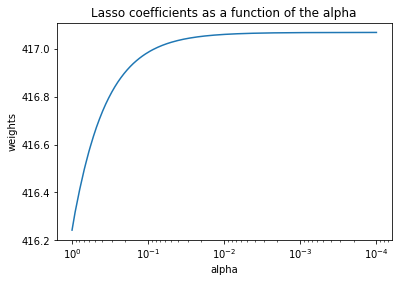

In [28]:
# Display results

ax = plt.gca()

ax.plot(alphas, coefs[:,0])
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the alpha')
plt.axis('tight')
plt.show()

In [29]:
# Which value of alpha would you recommend?

In [30]:
scorer = metrics.make_scorer(metrics.mean_absolute_error, greater_is_better = True)

In [31]:
lassocv = linear_model.LassoCV(alphas=alphas, normalize=True)
lassocv.fit(X_train, y_train)
lassocv_score = lassocv.score(X_test, y_test)
lassocv_alpha = lassocv.alpha_

In [32]:
lassocv_alpha

1.0

In [33]:
# another approach

In [34]:
tuned_parameters = {'alpha': np.logspace(-10, 0, 5)}
lasso = GridSearchCV(estimator=linear_model.Lasso(),param_grid=tuned_parameters)
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)
mape = mean_absolute_percentage_error(y_test, lasso_preds)
print 'Lasso mape: {}'.format(mape)

Lasso mape: 47.6555064096


In [35]:
lasso.best_estimator_.alpha

1.0

In [36]:
df_profits_sales = df_origin[df_origin['profits'] >= 0]

In [37]:
log_profits = np.array(np.log(df_profits_sales['profits'].values))
log_sales = np.array(np.log(df_profits_sales['sales'].values))

In [38]:
type(log_sales)

numpy.ndarray

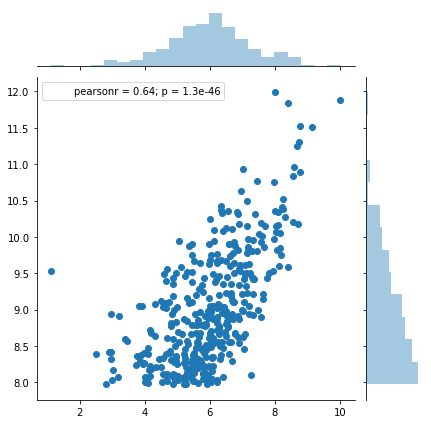

In [39]:
# Make a bivariate scatter plot
sns.jointplot(x=log_profits, y=log_sales)

In [40]:
# Create linear regression object
lregr = linear_model.LinearRegression()

In [41]:
# Train the model using the training sets
lregr.fit(log_sales.reshape(-1, 1), log_profits)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
# Make predictions using the testing set
lregr_y_pred = lregr.predict(log_sales.reshape(-1, 1))

In [43]:
# The intercept
print('Intercept: ', lregr.intercept_)

('Intercept: ', -3.1210892992114498)


In [44]:
# The coefficients
print('Coefficients: ', lregr.coef_)

('Coefficients: ', array([ 1.01099621]))


In [45]:
# The mean squared error
print("mean absolute percentage_error: %.2f"
      % mean_absolute_percentage_error(log_profits, lregr_y_pred))

mean absolute percentage_error: 15.12


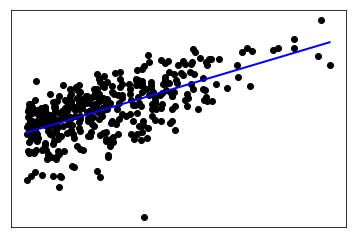

In [46]:
# Plot outputs
plt.scatter(log_sales.reshape(-1, 1), log_profits,  color='black')
plt.plot(log_sales.reshape(-1, 1), lregr_y_pred, color='blue', linewidth=2)

plt.xticks(())
plt.yticks(())

plt.show()

In [47]:
def func(x, intercept, coeff, power):
    return intercept + coeff * pow(x, power)

popt, pcov = curve_fit(func, log_sales, log_profits, p0=(0.0, 1.0, 2.0))

In [48]:
# the fit parameters
popt

array([ 1.11153934,  0.0890415 ,  1.81832607])

In [49]:
pcov

array([[ 8.74805335, -0.75632962,  3.03321528],
       [-0.75632962,  0.06581633, -0.26439227],
       [ 3.03321528, -0.26439227,  1.06256632]])

In [50]:
func_pred = func(log_sales, popt[0], popt[1], popt[2])

In [51]:
# The mean squared error
print("mean absolute percentage_error: %.2f"
      % mean_absolute_percentage_error(log_profits, func_pred))

mean absolute percentage_error: 15.11


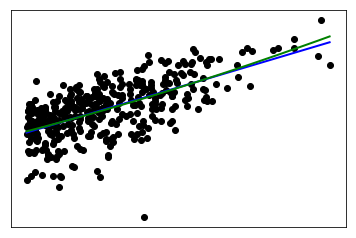

In [52]:
# Plot outputs
plt.scatter(log_sales.reshape(-1, 1), log_profits,  color='black')
plt.plot(log_sales.reshape(-1, 1), lregr_y_pred, color='blue', linewidth=2)
plt.plot(log_sales.reshape(-1, 1), func_pred, color='green', linewidth=2)
plt.xticks(())
plt.yticks(())

plt.show()

In [60]:
def model(x, intercept, coeff, power):
    return intercept +  coeff * pow(x, power)

In [61]:
def residuals(y, intercept, coeff, power):
    return y - model(intercept, coeff, power)

In [62]:
# initial
x0 = np.array([0, 1.0, 2.0], dtype=float)

In [63]:
x, flag = leastsq(residuals, x0, args=(log_sales))

TypeError: residuals() takes exactly 4 arguments (2 given)